In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from collections import Counter
from tqdm import tqdm
from datetime import datetime, timedelta, date
from collections import OrderedDict
import subprocess
from utils.functions import *
import seaborn as sns 
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import matplotlib.patheffects as path_effects
from scipy.spatial.distance import cosine
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from itertools import cycle
from sklearn.decomposition import PCA
import networkx as nx
import math
from utils.networks import *
import community
from matplotlib import cm
from itertools import islice


from networkx import edge_betweenness_centrality
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community.kclique import k_clique_communities

plotting.style(12)

In [2]:
def mss(model1,model2,word,k=25):
    if not word in model1.vocab or not word in model2.vocab:
        return 0
    neighborhood1 = [w for w,c in model1.most_similar(word,topn=k)]
    neighborhood2 = [w for w,c in model2.most_similar(word,topn=k)]
    meta_neighborhood = list(set(neighborhood1)|set(neighborhood2))
    meta_neighborhood = [w for w in meta_neighborhood if w in model1.vocab and w in model2.vocab]
    vector1 = [model1.similarity(word,w) for w in meta_neighborhood]
    vector2 = [model2.similarity(word,w) for w in meta_neighborhood]
    return cosine(vector1,vector2)

In [3]:
# lf = sorted(gb("/home/ruben/Documents/GitHub/CrisisBureaucracy/results/w2v-models/*w24*"))
# d = []
# for c,m in enumerate(lf):
#     if c == 0:
#         continue 
#     else:
#         try:
#             mc = KeyedVectors.load_word2vec_format(m,binary=True)
#             mp = KeyedVectors.load_word2vec_format(lf[c-1],binary=True)
#             d.append([m[-23:-14],mss(mp,mc,"bureaucracy_labour"),mss(mp,mc,"bureaucracy_conservative")])
#         except:
#             continue

# d = pd.DataFrame(d,columns=["y","slab",'scon'])
# d['y'] = [x[:9] for x in d['y']]
# d.plot.bar(x='y',y=['slab','scon'],color=["salmon","teal"],figsize=(10,6))
# plt.legend(["Labour","Conservative"],fontsize=20)
# plt.xlabel('Years (Two Year Sliding Window)',labelpad=20)

In [4]:
# def top_words_table(sorted_fns,word,iter_=1,topn=15):
#     d = pd.DataFrame()

#     for c in list(range(0,len(sorted_fns),iter_)):
#         mc = KeyedVectors.load_word2vec_format(lf[c],binary=True)
#         if word in set(mc.wv.vocab):
#             ms = mc.wv.most_similar(word,topn=topn)
#             ms = [x[0] for x in ms]
#             d[lf[c][-23:-14]] = ms
#         else:
#             continue
#     return d
# df = top_words_table(lf,"bureaucracy_conservative",iter_=3,topn=25)
# df.to_csv('/home/ruben/Documents/GitHub/CrisisBureaucracy/results/tables/w2v-topterms-bureaucracy_marked-iter3-topn25.csv',index=False)

In [5]:
# def plot_similarity(word1,word2,lf):
#     d = []
#     for m in lf:
#         mo = KeyedVectors.load_word2vec_format(m,binary=True)
#         if word1 in mo.wv.vocab and word2 in mo.wv.vocab:
#             d.append([m[-23:-14],mo.wv.similarity(word1,word2)])
#     d = pd.DataFrame(d,columns=['1','2'])
#     d.plot.bar(x='1',y='2',figsize=(10,5),legend=False)

In [3]:
def GetNetwork(model, word, n):
    dft = pd.DataFrame()
    for wl1 in list(dict(model.most_similar(word, topn=n)).keys()):
        for wl2 in list(dict(model.most_similar(wl1, topn=n)).keys()):
            for wl3 in list(dict(model.most_similar(wl2, topn=n)).keys()):
                # for wl4 in list(dict(model.most_similar(wl3, topn=n)).keys()):
                source = wl2
                target = wl3
                t = pd.DataFrame([source, target]).T
                dft = dft.append(t)
    dft.columns = ['source', 'target']
    dft['count'] = [model.wv.vocab[w].count for w in list(dft.target)]
    return dft

In [41]:
sns.set(font='Fira Sans, Bold',rc={'axes.axisbelow': True,'axes.edgecolor': 'lightgrey','axes.facecolor': 'None', 'axes.grid': True,'grid.color':'whitesmoke','axes.labelcolor':'black','axes.spines.top': True,'figure.facecolor': 'white','lines.solid_capstyle': 'round','patch.edgecolor': 'w','patch.force_edgecolor': True,'text.color': 'dimgrey','xtick.bottom': False,'xtick.color': 'dimgrey','xtick.direction': 'out','xtick.top': False,'ytick.color': 'dimgrey','ytick.direction': 'out','ytick.left': False, 'ytick.right': False})

def plot_(word,year,number_most_similar=5,iterations=95,k=0.15,figsize=(24,16)):
    mo = KeyedVectors.load_word2vec_format(f'/home/ruben/Documents/GitHub/CrisisBureaucracy/results/w2v-models/{year}-{year+3}-w14-unstamped-model.bin',binary=True)
    df = GetNetwork(mo,word,number_most_similar)
    g = nx.from_pandas_edgelist(df, source='source', target='target') 
    targets = list(df.target.unique())
    source = list(df.source.unique())
    st = source + targets
    plt.figure(figsize=figsize)
    layout = nx.spring_layout(g,iterations=iterations,k=k)
    tsize = [g.degree(t) * 120 for t in targets]
    ssize = [g.degree(t) * 120 for t in source]

    # Communities
    gn_generator = girvan_newman(g, most_valuable_edge)
    gn_communities = next(islice(gn_generator, 3, None)) # Do 3 iterations only
    gn_dict_communities = {}

    for i, c in enumerate(gn_communities):
        for node in c:
            gn_dict_communities[node] = i + 1
            
    for node in g:
        if node not in gn_dict_communities.keys():
            gn_dict_communities[node] = -1

    gn_pos = community_layout(g, gn_dict_communities)
    # size = [g.degree(t) * 120 for t in target]
        
    colors = []
    for node in g.nodes:
        colors.append(cm.Paired(gn_dict_communities[node]))

    nx.draw_networkx_nodes(g, gn_pos, node_color=colors)
    # nx.draw_networkx_nodes(g, gn_pos, nodelist=targets, node_size=tsize, node_color=colors)
    # nx.draw_networkx_nodes(g, gn_pos, nodelist=source, node_size=ssize, node_color=colors)
    nx.draw_networkx_edges(g, gn_pos, width=1, edge_color="#cccccc")
    node_labels = dict(zip(targets, targets))

    d = dict(g.degree)
    for node, (x, y) in gn_pos.items():
        plt.text(x, y, node, fontsize=math.log(d[node] * 6) * 5, ha='center', va='center',c='black')
    plt.title(f"Semantic Field of '{word}' ({year}-{year+3})",fontsize=30)
    plt.savefig(f'/home/ruben/Documents/GitHub/CrisisBureaucracy/results/plots/semanticfield-{word}-{year}_{year+3}.png',dpi=300,bbox_inches='tight')
    plt.show()

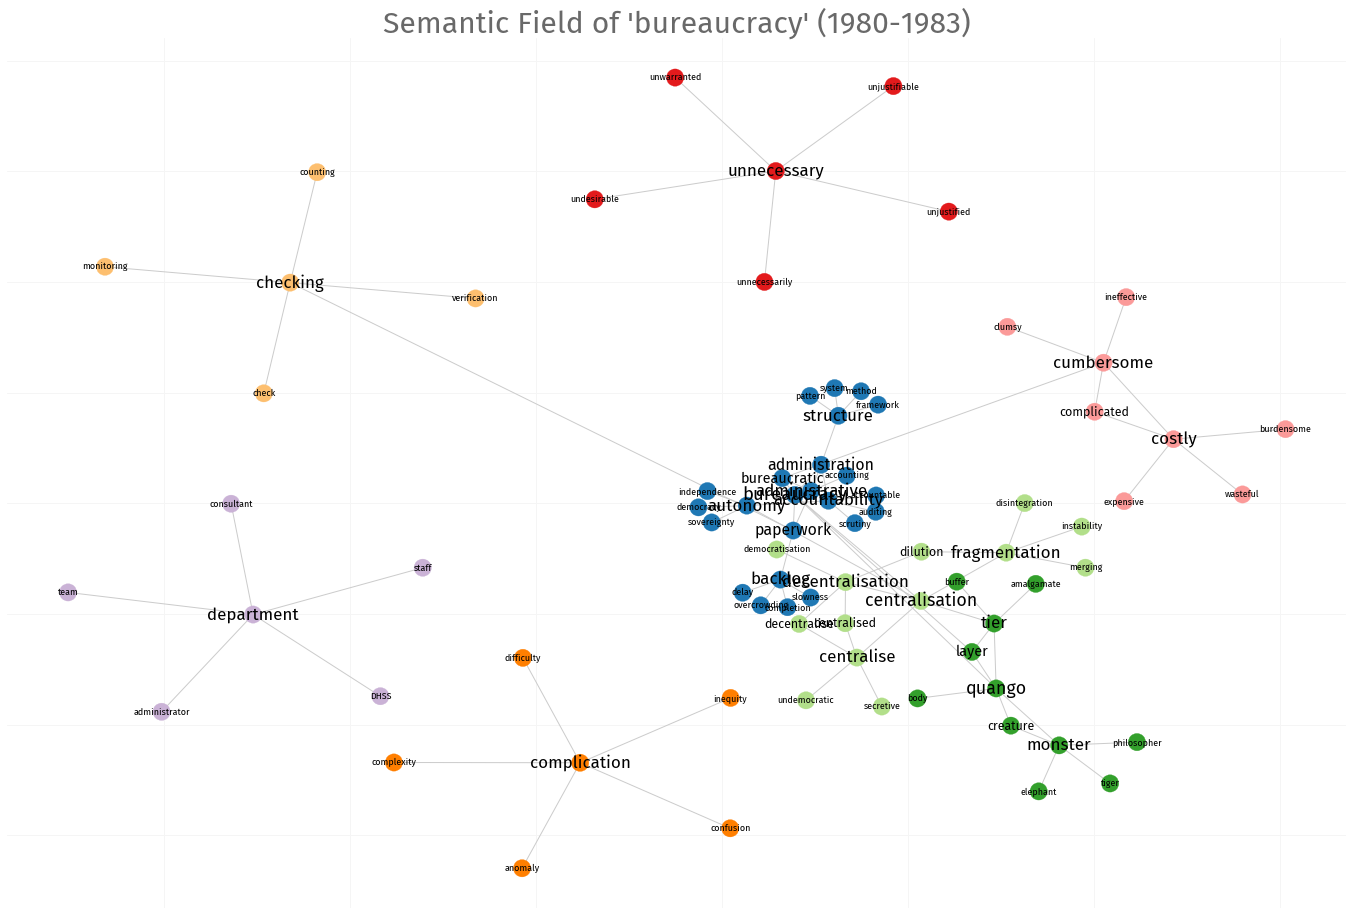

In [57]:
plot_('bureaucracy',1980,k=0.3,figsize=(24,16))